In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
prosit_peps = pd.read_csv("/data/yejb/prosit/figs/boosting/figs/Figure_5_Mel15/forPride/rescoring_for_paper_2/percolator/prosit_target.peptides", sep='\t')
prosit_peps = {k.strip("_").strip(".").upper() : v for k, v in zip(prosit_peps['peptide'], prosit_peps['q-value'])}
ft_peps = pd.read_csv("/data/yejb/prosit/figs/boosting/figs/Figure_5_Mel15/percolator_hdf5_0.1/prosit_target.peptides", sep='\t')
ft_peps = {k.strip("_").strip(".").upper() : v for k, v in zip(ft_peps['peptide'], ft_peps['q-value'])}

In [21]:
from tqdm import tqdm
FASTA = "/data/yejb/prosit/figs/boosting/figs/Figure_5_Mel15/Mel15OP1_mut_only.fasta"

def if_mutation(d):
    return "|" in d


def filter_prefixs(data, prefixs):
    new_data = []

    def check(f: str):
        for p in prefixs:
            if f.startswith(p):
                return True
        return False

    for pack in data:
        mut_flag = pack[0]
        for f in mut_flag.split('|'):
            if check(f):
                new_data.append(pack)
                break
    return new_data


def read_mut(mut_fasta):
    mut_pair = []
    with open(mut_fasta) as f:
        for l in f:
            l = l.strip()
            if l.startswith(">"):
                mut_pair.append([l])
            else:
                mut_pair[-1].append(l)
    return mut_pair


def extract_loc(data):
    all_locs = []
    new_data = []
    can_not_parse = 0
    out_bound = 0
    for pack in data:
        mut_flag = pack[0]
        missense = mut_flag.split("|")

        try:
            mis_loc = int(missense[11])
        except:
            can_not_parse += 1
            continue
        try:
            assert mis_loc <= len(pack[1])
            assert mis_loc > 0
        except:
            out_bound += 1
            continue
            # raise
        new_data.append(pack)
        all_locs.append(mis_loc)
    print(f"{len(data)}, {can_not_parse}, {out_bound}")
    return all_locs, new_data


def check_missense_overlap(target, pep, loc):
    possible_left = max(0, loc - len(pep))
    possible_right = min(len(target), loc + len(pep) - 1)
    possible_area = target[possible_left:possible_right]
    return (pep.lower() in possible_area.lower())


def check_frameshift_overlap(target, pep, loc):
    possible_left = max(0, loc - len(pep))
    possible_area = target[possible_left:]
    return (pep.lower() in possible_area.lower())


def if_frameshift(data):
    return "frameshift_variant" in data


def if_missense(data):
    return "missense" in data

protein_groups = pd.read_csv(
    '/data/yejb/prosit/figs/boosting/figs/Figure_5_Mel15/forPride/txt/peptides.txt', sep='\t')
protein_groups = protein_groups[protein_groups['Reverse'] != '+']
protein_groups = protein_groups[protein_groups['Proteins'].apply(
    lambda x: all([if_mutation(p) for p in x.split(";")]))]
LEGAL_PEPS = set(protein_groups['Sequence'])



/home/yejb/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (84) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [22]:
legal_mut_peps = set([p.upper() for p in LEGAL_PEPS])
legal_mut_peps = legal_mut_peps.intersection(set(list(prosit_peps)))
legal_mut_peps = legal_mut_peps.intersection(set(list(ft_peps)))

print(f"total {len(legal_mut_peps)} peptides to search")
MUT_DATA = filter_prefixs(
    read_mut(FASTA), ["missense", "frameshift_variant", "non_coding_transcript_exon_variant"])
MUT_LOC, MUT_DATA = extract_loc(MUT_DATA)
print(f"Total {len(MUT_DATA)} mutation to check")

all_mut_peps = []

for pep in tqdm(legal_mut_peps):
    for mut_loc, mut_core in zip(MUT_LOC, MUT_DATA):
        core_pep = mut_core[1]
        if if_frameshift(mut_core[0]) and check_frameshift_overlap(core_pep, pep, mut_loc):
            all_mut_peps.append(pep)
            break
        elif check_missense_overlap(core_pep, pep, mut_loc):
            all_mut_peps.append(pep)
            break

all_mut_peps = set(all_mut_peps)
print(f"Total {len(all_mut_peps)} available mutation peptides")


total 5497 peptides to search
48101, 1, 676
Total 47424 mutation to check


100%|██████████| 5497/5497 [07:11<00:00, 12.74it/s]

Total 2937 available mutation peptides


2937
2937


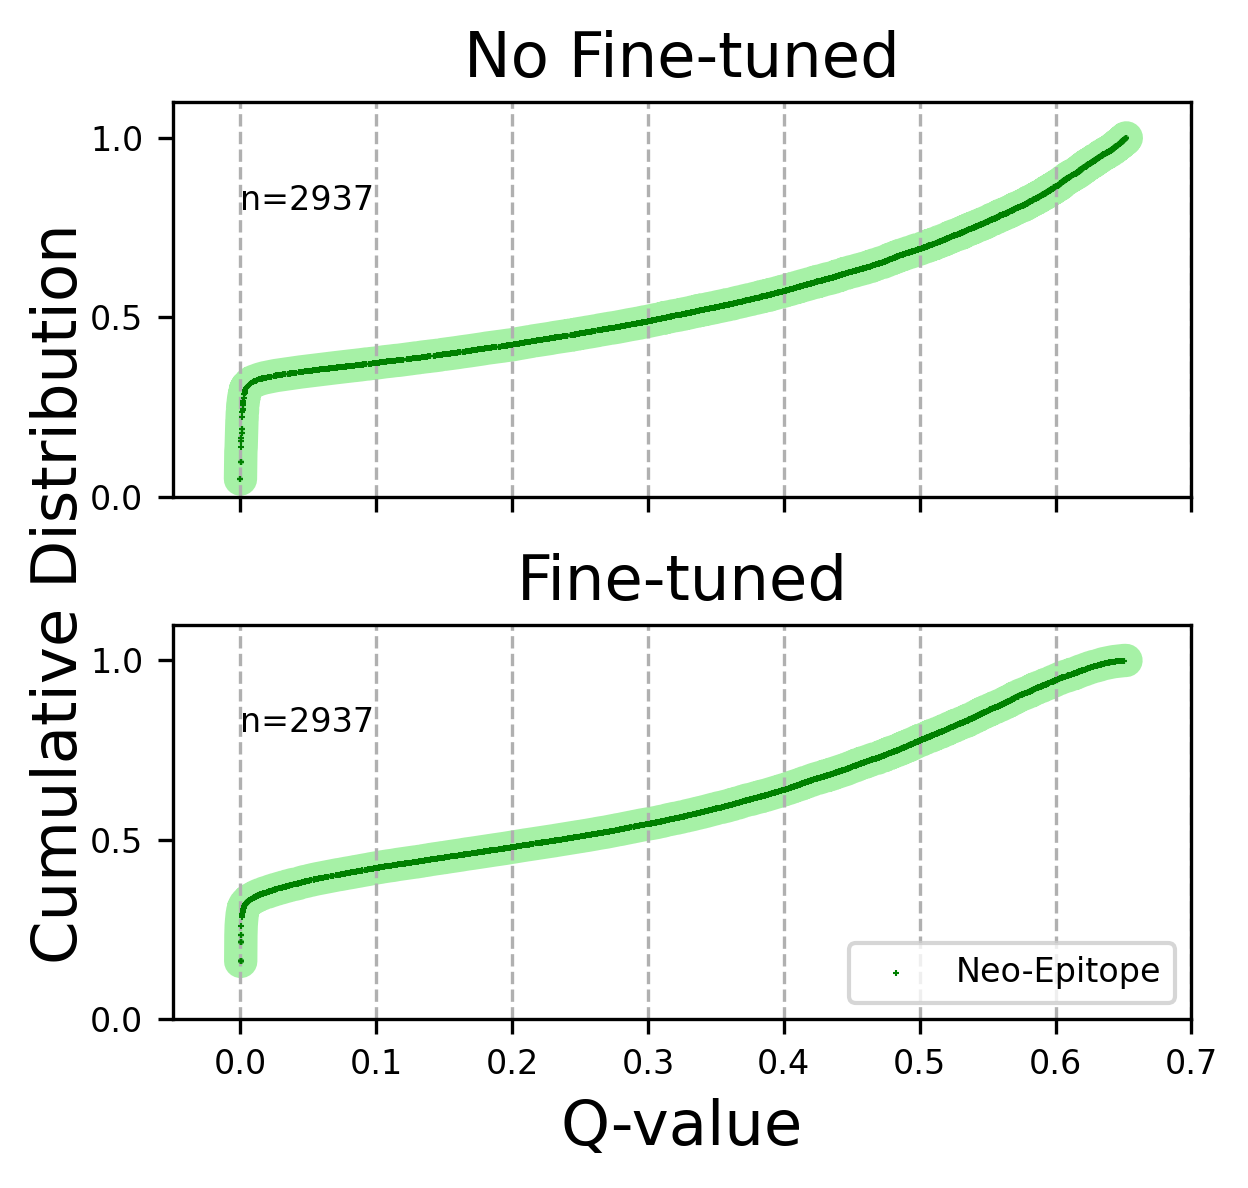

In [28]:
def plot_cums_with_highlight(score_dict1, score_dict2, pick_pep, label="No Fine-tuned"):
    import matplotlib as mpl
    plt.style.use(['ieee', "high-vis", 'no-latex'])
    plt.rcParams["font.family"] = "DejaVu Sans"
    
    fig, axs = plt.subplots(2, figsize=(4, 4), dpi=300)
    
    max_q = 0.7
    for i, (ax, score_dict) in enumerate(zip(axs, [score_dict1, score_dict2])):
        scores = np.array(list(score_dict.values()))
        scores = scores[scores < max_q]
        t_v, t_base = np.histogram(scores, bins=9000)
        t_base = t_base[:-1]
        t_cum_sum = np.cumsum(t_v) / len(scores)
        
        ax.plot(t_base, t_cum_sum, linewidth=8, alpha=.8, c='lightgreen',zorder=0, solid_capstyle='round')
        
        which_bin = []
        which_num = []
        c_count = 0
        for pep in pick_pep:
            if pep in score_dict:
                if score_dict[pep] < max_q:
                    c_count += 1
                    this_bin = np.argsort(np.abs(t_base - score_dict[pep]))[0]
                    which_bin.append(t_base[this_bin])
                    which_num.append(t_cum_sum[this_bin])
        print(c_count)
        ax.scatter(which_bin, which_num, label='Neo-Epitope', marker='+', linewidths=0.5, s=2, c='green', zorder=5)
        ax.set_ylim((0., 1.1))
        ax.set_xlim((-0.05, max_q))
        if i == 0:
            ax.set_xticklabels([])
            ax.set_title("No Fine-tuned", fontsize=15)
        else:
            ax.set_title("Fine-tuned", fontsize=15)
        ax.xaxis.grid(linestyle='--')
        ax.text(0, 0.8, f"n={len(which_bin)}", fontsize=8)
    ax.set_xlabel("Q-value", fontsize=15)
    ax.legend(loc="lower right")
    # axs[0].set_ylabel('Cumulative Distribution', fontsize=10)
    # ax.set_xlim((0, 0.03))
    fig.tight_layout()
    fig.text(-0.02, 0.5, 'Cumulative Distribution',
            va='center', rotation='vertical', fontsize=15)
    mpl.rcParams.update(mpl.rcParamsDefault)
    return fig, ax
fig, ax = plot_cums_with_highlight(prosit_peps, ft_peps, all_mut_peps)